[toc]

# RNN 时间序列预测股票价格

这个问题本身没有什么价值，但是还是有一些思考的价值。

## 思考

### 网络结构

在一个时序问题中，我们常常希望用之前的信息来预测之后的信息。如用之前的 20 步的数据来预测第 21 步的数据。此时，我们的网络结构是这个样子的。

![](https://gitee.com/EdwardElric_1683260718/picture_bed/raw/master/img/20200728171725.png)

还有一个问题。我们的数据要用什么？如果我们要预测股票的开盘价，那么我们的数据可能是历史的开盘价。那么我们的输入数据维度是 `(batch_size, sequence_len, 1)` 而输出数据是 `(batch_size, 1)`

但是，我们除了历史的开盘价之外，还可以有其它的信息可以使用。历史的收盘价、历史的最大值等等。

假设我们使用历史的开盘价、收盘价、最大值、最小值来预测未来的开盘价，那么我们的输入数据的维度应该是 `(batch_size, sequence_len, 4)`, 而输出的维度仍然是 `(batch_size, 1)`

## 读入数据

In [202]:
import tushare as ts
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from matplotlib import pyplot as plt

maotai = ts.get_k_data('600519', ktype='D', start='2010-04-26', end='2020-04-26')
maotai.head()

本接口即将停止更新，请尽快使用Pro版接口：https://tushare.pro/document/2


,date,open,close,high,low,volume,code
74,2010-04-26,88.702,87.381,89.072,87.362,107036.13,600519
75,2010-04-27,87.355,84.841,87.355,84.681,58234.48,600519
76,2010-04-28,84.235,84.318,85.128,83.597,26287.43,600519
77,2010-04-29,84.592,85.671,86.315,84.592,34501.20,600519
78,2010-04-30,83.871,82.340,83.871,81.523,85566.70,600519


## 划分训练集和验证集

In [174]:
sample_size = maotai.shape[0]
val_size = 300 # 后300天做验证
train_size = sample_size - val_size

In [192]:
training_set = maotai[['open']][:train_size].values
validation_set = maotai[['open']][train_size:].values

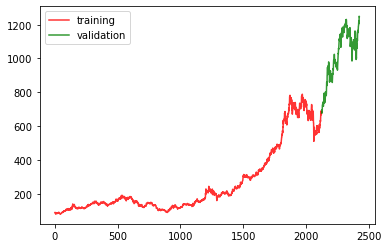

In [193]:
plt.plot(training_set, label='training', color='red', alpha=0.8)
plt.plot(range(train_size, sample_size), validation_set, label='validation', color='green', alpha=0.8)
plt.legend()

## 归一化

In [194]:
scaler = MinMaxScaler()
training_set_scaled = scaler.fit_transform(training_set)
validation_set_scaled = scaler.transform(validation_set)
sequence_len = 60

将数据整理成序列数据，这样才可以输入 RNN

In [196]:
def get_sequence_data(data):  
    x_sequence = np.array([data[i-sequence_len:i] for i in range(sequence_len, len(data))])
    y_sequence = np.array([data[i] for i in range(sequence_len, len(data))])
    yield x_sequence, y_sequence

In [197]:
train_data_generator = get_sequence_data(training_set_scaled)
valid_data_generator = get_sequence_data(validation_set_scaled)

In [118]:
np.random.seed(7)
shuffled_idx = np.random.permutation(x_train.shape[0])

In [198]:
print(f"x_train.shape: {x_train.shape} y_train.shape: {y_train.shape} x_val.shape: {x_val.shape} y_val.shape: {y_val.shape}")

x_train.shape: (2066, 60, 1) y_train.shape: (2066, 1) x_val.shape: (240, 60, 1) y_val.shape: (240, 1)


{{x_train.shape}} 表示有 {{x_train.shape[0]}} 个样本，每个样本中都有 {{x_train.shape[1]}} 个序列，每个序列都有 {{x_train.shape[2]}} 个特征

## 构建模型

In [206]:
model = tf.keras.Sequential([
    SimpleRNN(80, dropout=0.5, return_sequences=True), # 这个要用 return_sequences，因为之后还接了一个 RNN
    SimpleRNN(100, dropout=0.5),
    Dense(50, activation='relu'),
    Dense(1) # 因为是回归问题，所以不用过激活函数
])

model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss='mse')

earlystop = tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss')
history = model.fit(x_train[shuffled_idx], y_train[shuffled_idx], batch_size=64, epochs=100, validation_data=(x_val, y_val))

Train on 2066 samples, validate on 240 samples
Epoch 1/100
2066/2066 [==============================] - 2s 1ms/sample - loss: 0.0827 - val_loss: 0.4796
Epoch 2/100
2066/2066 [==============================] - 1s 473us/sample - loss: 0.0506 - val_loss: 0.5525
Epoch 3/100
2066/2066 [==============================] - 1s 440us/sample - loss: 0.0425 - val_loss: 0.3847
Epoch 4/100
2066/2066 [==============================] - 1s 493us/sample - loss: 0.0457 - val_loss: 0.6060
Epoch 5/100
2066/2066 [==============================] - 1s 500us/sample - loss: 0.0449 - val_loss: 0.5549
Epoch 6/100
2066/2066 [==============================] - 1s 464us/sample - loss: 0.0406 - val_loss: 0.5866
Epoch 7/100
2066/2066 [==============================] - 1s 502us/sample - loss: 0.0425 - val_loss: 0.4556
Epoch 8/100
2066/2066 [==============================] - 1s 458us/sample - loss: 0.0457 - val_loss: 0.4620
Epoch 9/100
2066/2066 [==============================] - 1s 443us/sample - loss: 0.0410 - val_loss:

2066/2066 [==============================] - 1s 648us/sample - loss: 0.0378 - val_loss: 0.5612
Epoch 77/100
2066/2066 [==============================] - 1s 616us/sample - loss: 0.0403 - val_loss: 0.4603
Epoch 78/100
2066/2066 [==============================] - 1s 620us/sample - loss: 0.0415 - val_loss: 0.5000
Epoch 79/100
2066/2066 [==============================] - 1s 633us/sample - loss: 0.0389 - val_loss: 0.6027
Epoch 80/100
2066/2066 [==============================] - 1s 628us/sample - loss: 0.0391 - val_loss: 0.4816
Epoch 81/100
2066/2066 [==============================] - 1s 633us/sample - loss: 0.0374 - val_loss: 0.5240
Epoch 82/100
2066/2066 [==============================] - 1s 620us/sample - loss: 0.0400 - val_loss: 0.5457
Epoch 83/100
2066/2066 [==============================] - 1s 605us/sample - loss: 0.0396 - val_loss: 0.5164
Epoch 84/100
2066/2066 [==============================] - 1s 592us/sample - loss: 0.0389 - val_loss: 0.5665
Epoch 85/100
2066/2066 [=================

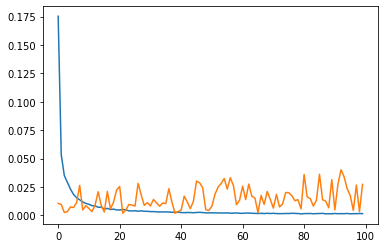

In [185]:
plt.plot(history.history['loss'], label="train_loss")
plt.plot(history.history['val_loss'], label="val_loss")

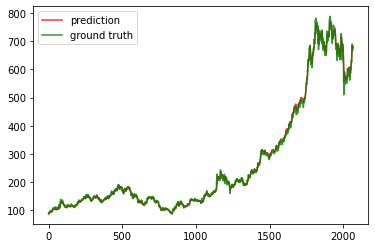

In [130]:
y_pred = model.predict(x_train)

plt.plot(scaler.inverse_transform(y_pred).squeeze(), label="prediction", color='red', alpha=0.8)
plt.plot(scaler.inverse_transform(y_train).squeeze(), label="ground truth", color='green', alpha=0.8)
plt.legend()

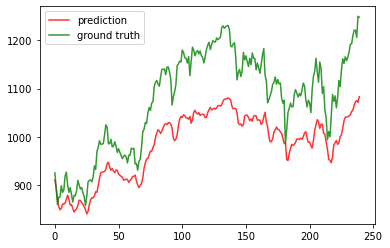

In [131]:
y_pred = model.predict(x_val)

plt.plot(scaler.inverse_transform(y_pred).squeeze(), label="prediction", color='red', alpha=0.8)
plt.plot(scaler.inverse_transform(y_val).squeeze(), label="ground truth", color='green', alpha=0.8)
plt.legend()

预测最后  300 天

In [172]:
from collections import deque

window = deque(training_set_scaled[-sequence_len:].squeeze().tolist())
prediction_scaled = []
for i in range(300):
    y = model.predict(np.array(window).reshape(1, sequence_len, 1))
    prediction_scaled.append(y[0][0])
    window.popleft()
    window.append(prediction_scaled[-1])
prediction = scaler.inverse_transform(np.array(prediction_scaled).reshape(-1,1)).squeeze()

0.7123069930010699

0.7236001434230103

0.696778911170902

0.6897206921571892

0.696778911170902

0.6872079661883076

0.6671343913133087

0.65742228195044

0.6910758702078221

0.6753219253692153

0.678427541735249

0.6774393910733291

0.6840741169462191

0.6685460351160512

0.6842858635166305

0.6826624731434766

0.6741926103270214

0.665722747510566

0.6640993571374122

0.6855281100630439

0.6727809665242788

0.7179535682120401

0.7377024650124083

0.7299525405353517

0.7334816500422081

0.727270417310141

0.6996021987763871

0.7010138425791296

0.7176571230134642

0.7193652120147827

0.7306724788747504

0.722993136587831

0.7135492395474834

0.7179535682120401

0.6999127604129904

0.6925439797626743

0.6819566512421054

0.6801497471745949

0.6823942608209554

0.6911323359599318

0.6816743224815567

0.7475698551935787

0.7334393007281258

0.7155255408713229

0.7447748004641483

0.7412456909572921

0.7475839716316061

0.7576631083831878

0.7687727451107716

0.7800658955327119

0.7728100463866153

0.8153569906012754

0.8224152096149882

0.8252384972204733

0.8605295922890368

0.8548830170780667

0.8283723464625617

0.8327202093750087

0.8405971817943121

0.8520597294725816

0.85062355

0.858479

0.862092

0.86711156

0.87101156

0.87068135

0.87118953

0.8722456

0.87507707

0.87549865

0.8745013

0.87808233

0.8782569

0.87917715

0.88268816

0.8828058

0.8815351

0.88130635

0.8804412

0.88174707

0.88125443

0.88361436

0.88539237

0.884782

0.88568914

0.8860909

0.8857143

0.8868429

0.8861313

0.88683444

0.8871224

0.88809395

0.88911825

0.88916713

0.8898708

0.890212

0.88880205

0.8886172

0.8881333

0.88852644

0.8886042

0.8891535

0.88917017

0.8889159

0.8893614

0.8896732

0.88954425

0.88979656

0.8896725

0.8896161

0.8893931

0.8899623

0.8906056

0.8910707

0.8916987

0.8919805

0.89191806

0.8921806

0.8922654

0.89251596

0.8927455

0.89310735

0.8934993

0.8937837

0.8940877

0.8944163

0.8946228

0.89494956

0.8951725

0.8953345

0.8954874

0.8957087

0.89596015

0.89621335

0.89645225

0.89668965

0.8967903

0.89692724

0.89702326

0.89715177

0.8972773

0.89741594

0.8975442

0.8976565

0.8977756

0.89791805

0.8979966

0.89810187

0.89816016

0.8982203

0.89827746

0.8983563

0.8984556

0.89855295

0.89863914

0.8987189

0.89874506

0.89879155

0.8988285

0.8988709

0.89891034

0.8989484

0.8989817

0.8990144

0.8990498

0.8990959

0.8991257

0.8991575

0.89917463

0.8991837

0.89919144

0.89920866

0.8992312

0.8992587

0.8992845

0.89931005

0.8993242

0.89933944

0.89935094

0.89936334

0.8993765

0.89939165

0.89940524

0.8994194

0.89943355

0.8994523

0.89946866

0.8994856

0.89949906

0.8995103

0.8995209

0.8995334

0.89954674

0.8995628

0.89957744

0.8995933

0.89960533

0.89961773

0.89962953

0.8996408

0.89965177

0.89966273

0.89967245

0.89968306

0.89969337

0.8997049

0.8997155

0.89972574

0.8997345

0.8997422

0.8997491

0.8997567

0.8997647

0.8997735

0.8997815

0.89978945

0.89979607

0.8998029

0.8998093

0.8998153

0.8998211

0.8998264

0.8998314

0.89983636

0.8998411

0.8998464

0.8998515

0.89985615

0.8998604

0.8998642

0.89986753

0.8998707

0.89987385

0.89987713

0.89988035

0.8998836

0.8998866

0.8998892

0.89989173

0.899894

0.89989626

0.89989835

0.8999004

0.8999021

0.89990383

0.89990586

0.89990765

0.89990944

0.899911

0.8999123

0.8999135

0.8999148

0.899916

0.89991736

0.8999187

0.8999199

0.899921

0.89992195

0.8999233

0.89992434

0.89992523

0.8999262

0.899927

0.899928

0.8999288

0.89992976

0.8999306

0.89993143

0.8999321

0.89993304

0.8999338

0.8999345

0.89993507

0.89993554

0.89993626

0.8999369

0.89993757

0.899938

0.89993864

0.8999393

0.8999399

0.8999403

0.8999406

0.89994115

0.8999414

0.89994174

0.8999424

0.8999429

0.8999433

0.89994365

0.899944

0.89994437

0.8999447

0.8999451

0.89994556

0.89994586

0.8999462

0.8999466

0.8999468

0.899947

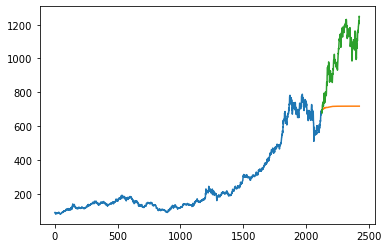

In [170]:
plt.plot(training_set)
plt.plot(range(train_size, sample_size), prediction)
plt.plot(range(train_size, sample_size), validation_set)

dict_keys(['loss', 'val_loss'])

In [ ]:
tf